# ITMAL Exercise

## Pipelines

We now try building af ML pipeline. The data for this exercise is the same as in L01, meaning that the OECD data from the 'intro.ipynb' have been save into a Python 'pickle' file. 

The pickle library is a nifty data preservation method in Python, and from L01 the tuple `(X, y)` have been stored to the pickle file `tmal_l01_data.pkl', try reloading it..

In [65]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def LoadDataFromL01():
    import pickle
    filename = "Data/itmal_l01_data.pkl"
    with open(f"{filename}", "rb") as f:
        (X, y) = pickle.load(f)
        return X, y

X, y = LoadDataFromL01()

print(f"X.shape={X.shape},  y.shape={y.shape}")

assert X.shape[0] == y.shape[0]
assert X.ndim == 2
assert y.ndim == 1  # did a y.ravel() before saving to picke file
assert X.shape[0] == 29

# re-create plot data (not stored in the Pickel file)
m = np.linspace(0, 60000, 1000)
M = np.empty([m.shape[0], 1])
M[:, 0] = m

print("OK")

X.shape=(29, 1),  y.shape=(29,)
OK


###  Revisiting the problem with the MLP

Using the MLP for the QECD data in Qd) from `intro.ipynb` produced a negative $R^2$, meaning that it was unable to fit the data, and the MPL model was actually _worse_ than the naive $\hat y$ (mean value of y).

Let's just revisit this fact. When running the next cell you should now see an OK $~R^2_{lin.reg}~$ score and a negative $~R^2_{mlp}~$ score..

The MLP mis-fits the data, seen in the bad R^2 score..
lin.reg.score(X, y)=0.73
MLP.score(X, y)=-5.71
OK


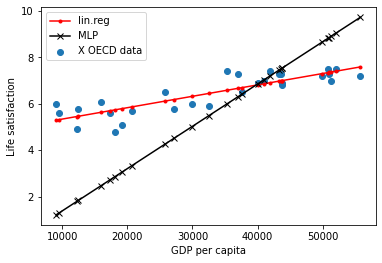

In [66]:
# Setup the MLP and lin. regression again..

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score

def PlotModels(model1, model2, X, y, name_model1="lin.reg", name_model2="MLP"):

    # NOTE: local function is such a nifty feature of Python!
    def CalcPredAndScore(model1, model2, X, y):
        y_pred_model1 = model1.predict(X)
        y_pred_model2 = model2.predict(X)

        # call r2
        score_model1 = r2_score(y, y_pred_model1)
        score_model2 = r2_score(y, y_pred_model2)

        return y_pred_model1, y_pred_model2, score_model1, score_model2

    y_pred_model1, y_pred_model2, score_model1, score_model2 = CalcPredAndScore(
        model1, model2, X, y)

    plt.plot(X, y_pred_model1, "r.-")
    plt.plot(X, y_pred_model2, "kx-")
    plt.scatter(X, y)
    plt.xlabel("GDP per capita")
    plt.ylabel("Life satisfaction")
    plt.legend([name_model1, name_model2, "X OECD data"])

    print(f"{name_model1}.score(X, y)={score_model1:0.2f}")
    print(f"{name_model2}.score(X, y)={score_model2:0.2f}")


# lets make a linear and MLP regressor and redo the plots

mlp = MLPRegressor(hidden_layer_sizes=(10, ),
                   solver='adam',
                   activation='relu',
                   tol=1E-5,
                   max_iter=100000,
                   verbose=False)
linreg = LinearRegression()

mlp.fit(X, y)
linreg.fit(X, y)

print("The MLP mis-fits the data, seen in the bad R^2 score..")
PlotModels(linreg, mlp, X, y)

print("OK")

### Qa) Create a Min/max scaler for the MLP

Now, the neurons in neural networks normally expect input data in the range `[0;1]` or sometimes in the range `[-1;1]`, meaning that for value outside this range then the neuron will saturate to its min or max value (also typical `0` or `1`). 

A concrete value of `X` is, say 22.000 USD, that is far away from what the MLP expects. Af fix to the problem in Qd), from `intro.ipynb`, is to preprocess data by scaling it down to something more sensible.

Try to manually scale X to a range of `[0;1]`, re-train the MLP, re-plot and find the new score from the rescaled input. Any better?

(If you already made exercise "Qe) Neural Network with pre-scaling" in L01, then reuse Your work here!) 

In [67]:
from sklearn.preprocessing import MinMaxScaler
from numpy import fabs

def MyMinMaxScaler(v):
    if isinstance(v, (type(list), type(np.array))):
        raise TypeError('input must be list or np.array')
    min = np.min(v)
    max = np.max(v)
    v_new = []
    for item in v:
        v_new.append((item-min)/(max-min))
    return v_new

scaler = MinMaxScaler()
scaler.fit(X)
sklearn_tmp = scaler.transform(X)
my_tmp = MyMinMaxScaler(X)

eps = 1E-9
for i in range(len(X)):
    assert fabs(my_tmp[i]-sklearn_tmp[i])<eps, f"Diff between my_tmp and sklearn_tmp: my_tmp[{i}]: {my_tmp[i]}, sklearn_tmp[{i}]: {sklearn_tmp[i]}"


### Qb) Scikit-learn Pipelines

Now, rescale again, but use the `sklearn.preprocessing.MinMaxScaler`.

When this works put both the MLP and the scaler into a composite construction via `sklearn.pipeline.Pipeline`. This composite is just a new Scikit-learn estimator, and can be used just like any other `fit-predict` models, try it, and document it for the journal.

(You could reuse the `PlotModels()` function by also retraining the linear regressor on the scaled data, or just write your own plot code.)

Pipe (MLP scaled).score(X, y)=0.71
Linreg.score(X, y)=0.73


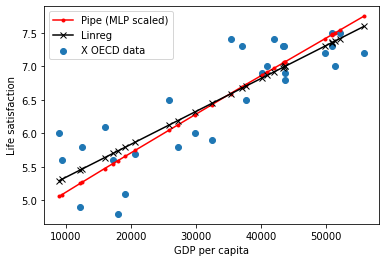

In [68]:
from sklearn.pipeline import Pipeline

scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('mlp', mlp)
])

pipe.fit(X,y)
PlotModels(pipe, linreg, X, y, name_model1="Pipe (MLP scaled)", name_model2="Linreg")

### Qb answer:<br>
It can be seen that the MLP model scores much better when the data is scaled. (Compared to the other MLP data from the introduction)

### Qc) Outliers and the Min-max Scaler vs. the Standard Scaler

Explain the fundamental problem with a min-max scaler and outliers. 

Will a `sklearn.preprocessing.StandardScaler` do better here, in the case of abnormal feature values/outliers?

Pipe (MLP, MinMax Scaled).score(X, y)=0.72
Pipe2 (MLP, StandardScaler).score(X, y)=0.71
Max in X: 55805.204000000005
Min in X: 9054.914
Mean in X: 33391.74913793103
Std in X: 14395.272687078264
 
2*Std+mean in X: 62182.29451208756
2*Std-mean in X: 4601.203763774502


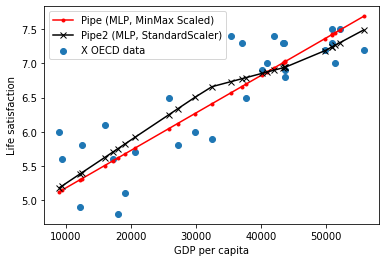

In [75]:
from sklearn.preprocessing import StandardScaler

mlp2 = MLPRegressor(hidden_layer_sizes=(10, ),
                   solver='adam',
                   activation='relu',
                   tol=1E-5,
                   max_iter=100000,
                   verbose=False)

pipe2 = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', mlp2)
])
pipe.fit(X,y)
pipe2.fit(X,y)


PlotModels(pipe, pipe2, X, y, name_model1="Pipe1 (MLP, MinMax Scaled)", name_model2="Pipe2 (MLP, StandardScaler)")

print(f"Max in X: {X.max()}")
print(f"Min in X: {X.min()}")
print(f"Mean in X: {X.mean()}")
print(f"Std in X: {X.std()}")
print(" ")
print(f"2*Std+mean in X: {2*X.std()+X.mean()}")
print(f"2*Std-mean in X: {-2*X.std()+X.mean()}")


### Qc answer:<br>
The fundamental problem with min-max scalers is that the scale will be heavily affected by outliers in cases where the outlier is significantly larger or smaller than the majority of the data-points.

In the code cell above it can be seen that the mean in X is $\approx33000$ and standard deviation of $\approx14000$. A general rule of thumb is to categorize an outlier as a data-point with values between $\pm2\cdot\sigma+\mu$, which is values between $\approx62000$ and $\approx4600$. Since the maximum and minimum is between these values it means that we do not have any significant outliers in the dataset.

Furthermore it can be seen from the scores that the models perform nearly identically. Pipe1 has a score $\approx0.72$ and Pipe2 has a score $\approx0.71$.

### Qd) Modify the MLP Hyperparameters

Finally, try out some of the hyperparameters associated with the MLP.

Specifically, test how few neurons the MLP can do with---still producing a sensible output, i.e. high $R^2$. 

Also try-out some other activation functions, ala sigmoid, and solvers, like `sgd`.

Notice, that the Scikit-learn MLP does not have as many adjustable parameters, as a Keras MLP, for example, the Scikit-learn MLP misses neurons initialization parameters (p. 333-334 [HOML]) and the ELU activation function (p. 336 [HOML]).

OPTIONAL$_1$: use a Keras MLP regressor instead of the Scikit-learn MLP (You need to install the  Keras if its not installed as default).

OPTIONAL$_2$: try out the `early_stopping` hyperparameter on the `MLPRegressor`. 

OPTIONAL$_3$: try putting all score-calculations into K-fold cross-validation  methods readily available in Scikit-learn using

* `sklearn.model_selection.cross_val_predict`
* `sklearn.model_selection.cross_val_score` 

or similar (this is, in theory, the correct method, but can be hard to use due to the  extremely small number of data points, `n=29`).

In [89]:
from sklearn.model_selection import train_test_split

X, y = LoadDataFromL01() # Reload data to be sure
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

mlp_og = MLPRegressor(hidden_layer_sizes=(10, ),
                   solver='adam',
                   activation='relu',
                   tol=1E-5,
                   max_iter=100000,
                   verbose=False)

pipe_og = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp_og', mlp_og)
])

pipe_og.fit(X_train, y_train)
print("OK")


OK


pipe_og.score(X, y)=0.76
new pipe.score(X, y)=0.72


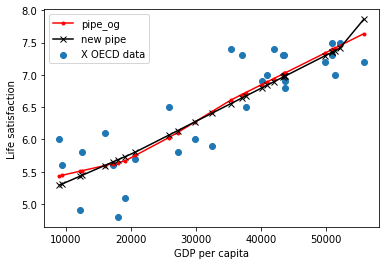

In [91]:
# hidden_layer = 5

mlp = MLPRegressor(hidden_layer_sizes=(5, ),
                   solver='adam',
                   activation='relu',
                   tol=1E-5,
                   max_iter=100000,
                   verbose=False)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', mlp)
])

pipe.fit(X, y)

PlotModels(pipe_og, pipe, X, y, name_model1="pipe original", name_model2="new pipe")

pipe_og.score(X, y)=0.76
new pipe.score(X, y)=0.73


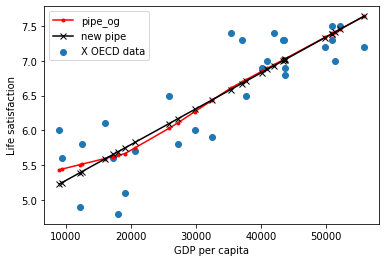

In [92]:
# hidden_layer = 1

mlp = MLPRegressor(hidden_layer_sizes=(1, ),
                   solver='adam',
                   activation='relu',
                   tol=1E-5,
                   max_iter=100000,
                   verbose=False)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', mlp)
])

pipe.fit(X, y)

PlotModels(pipe_og, pipe, X, y, name_model1="pipe original", name_model2="new pipe")

pipe original.score(X, y)=0.76
new pipe.score(X, y)=0.71


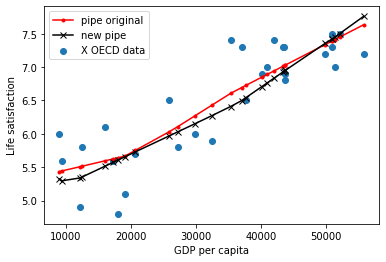

In [93]:
# hidden_layer = 10, solver = 'sgd' (stochastic gradiant descent)

mlp = MLPRegressor(hidden_layer_sizes=(10, ),
                   solver='sgd',
                   activation='relu',
                   tol=1E-5,
                   max_iter=100000,
                   verbose=False)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', mlp)
])

pipe.fit(X, y)

PlotModels(pipe_og, pipe, X, y, name_model1="pipe original", name_model2="new pipe")

pipe original.score(X, y)=0.76
new pipe.score(X, y)=0.81


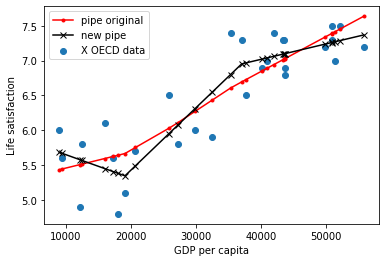

In [94]:
# hidden_layer = 10, solver = 'lbfgs' (stochastic gradiant descent)

mlp = MLPRegressor(hidden_layer_sizes=(10, ),
                   solver='lbfgs',
                   activation='relu',
                   tol=1E-5,
                   max_iter=100000,
                   verbose=False)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', mlp)
])

pipe.fit(X, y)

PlotModels(pipe_og, pipe, X, y, name_model1="pipe original", name_model2="new pipe")

pipe original.score(X, y)=0.76
new pipe.score(X, y)=0.73


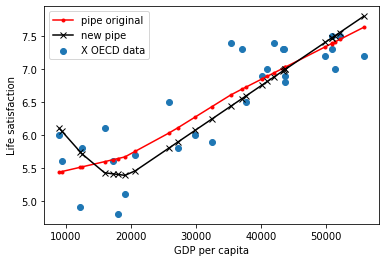

In [95]:
# hidden_layer = 10, early_stopping = True

mlp = MLPRegressor(hidden_layer_sizes=(10, ),
                   solver='adam',
                   activation='relu',
                   tol=1E-5,
                   max_iter=100000,
                   early_stopping=True,
                   verbose=False)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', mlp)
])

pipe.fit(X, y)

PlotModels(pipe_og, pipe, X, y, name_model1="pipe original", name_model2="new pipe")

In [ ]:
# hidden_layer = 10, activation='identity'

mlp = MLPRegressor(hidden_layer_sizes=(10, ),
                   solver='adam',
                   activation='identity',
                   tol=1E-5,
                   max_iter=100000,
                   verbose=False)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', mlp)
])

pipe.fit(X, y)

PlotModels(pipe_og, pipe, X, y, name_model1="pipe original", name_model2="new pipe")

REVISIONS| |
---------| |
2020-1015| CEF, initial. 
2020-1021| CEF, added Standard Scaler Q.
2020-1117| CEF, removed orhpant text in Qa (moded to Qc).
2021-0210| CEF, updated for ITMAL F21.